In [31]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import unittest

In [32]:
class Integral:
    @classmethod
    def integrate_quad(cls, f, a, b, N=10000):
        x = np.linspace(a, b, N)
        s = sum([f(i) for i in x])
        return s*abs(b-a)/N

In [33]:
class Lagguerre:
    def __init__(self, beta, sigma):
        self.beta = beta
        self.sigma = sigma
        self.experiment_value = None
        
    @property
    def beta(self):
        return self._beta
    
    @beta.setter
    def beta(self, value):
        self._beta = value
    
    @property
    def sigma(self):
        return self._sigma
    
    @sigma.setter
    def sigma(self, value):
        self._sigma = value
    
    def laguerre(self, t, n):
        if self.beta < 0 or self.beta > self.sigma:
            raise ValueError("Wrong parameters")
        

        lpp = np.sqrt(self.sigma)*np.exp(-self.beta*t/2)

        lp = np.sqrt(self.sigma)*(1 - self.sigma*t)*np.exp(-self.beta*t/2)

        if n == 0:
            return lpp
        if n == 1:
            return lp

        for i in range(2, n+1):
            temp = lp
            lp = (2*i -1 -self.sigma*t)*lp/i - (i-1)*lpp / i
            lpp = temp
        
        return lp
    
    def tabulate_laguerre(self, T, n):
        t = np.linspace(0, T, 100)
        results = self.laguerre(t, n)
        df = pd.DataFrame({'t': t, 'l': results})
        return df.round(5)
    
    def experiment(self, T, epsilon=1e-3, N=20):
        t = np.linspace(0, T, 1000)
        n = range(1, N+1)
        result = None
        for i in t:
            flag = True
            for j in n:
                if abs(self.laguerre(i, j)) > epsilon:
                    flag = False
                    break
            if flag and result is None:
                result = i
        

        cols = {"t" : t}
        for j in n:
            cols[f"n={j}"] = self.laguerre(t, j)

        df = pd.DataFrame(cols)

        self.experiment_value = result

        return result, df.round(5)
    
    

    def laguerre_transformation(self, f, n):
        def integrand(t):
            return f(t)*self.laguerre(t, n)*np.exp(-t*(self.sigma-self.beta))
        b = self.experiment(100)[0]
        if b is None:
            return Integral.integrate_quad(integrand, 0, np.inf)

        return Integral.integrate_quad(integrand, 0, b)
    
    def tabulate_transformation(self, f, N):
        results = [self.laguerre_transformation(f, n) for n in range(N+1)]
        
        return results
    
    def reversed_laguerre_transformation(self, h_list, t):
        result_sum = 0

        h_list_new = list(filter(lambda x: x != 0, h_list))

        for i in range(len(h_list_new)):
            result_sum += h_list_new[i]*self.laguerre(t, i)
        
        return result_sum
    
    



In [34]:
lag = Lagguerre(2, 4)

In [35]:
lag.laguerre(1, 2)

0.7357588823428847

In [36]:
lag.tabulate_laguerre(10, 2).head()

,t,l
0,0.00000,2.00000
1,0.10101,0.49453
2,0.20202,-0.47336
3,0.30303,-1.01868
4,0.40404,-1.23687


In [37]:
r, df = lag.experiment(100)
r

79.07907907907908

In [38]:
def f(t):
    if t >= 0 and t <= 2*np.pi:
        return np.sin(t-np.pi/2) + 1
    else:
        return 0

In [39]:
lag.tabulate_transformation(f, 20)

[0.06665999946809152,
 -0.1822039881310192,
 0.17805610913078898,
 -0.0742826695000306,
 0.007262784325811692,
 0.007587430478937864,
 -0.003096494945065475,
 -0.0006148703444646362,
 0.0007994250066752776,
 -2.5850153812011465e-05,
 -0.00023592602139502894,
 5.256960095504625e-05,
 9.381390277832641e-05,
 -3.0676683574269335e-05,
 -5.2658350956100556e-05,
 1.097528013689054e-05,
 3.616172697533956e-05,
 4.5476548832641705e-06,
 -2.3361494137766216e-05,
 -1.4823620942386276e-05,
 8.910978104645316e-06]

In [40]:
transfomormed_temp = lag.tabulate_transformation(f, 20)
lag.reversed_laguerre_transformation(transfomormed_temp, np.pi)

1.9997392005657693

In [61]:
class Plotter:
    def __init__(self, laguerre):
        self.laguerre = laguerre
    
    def plot_laguerre(self, T, N):
        plt.close("all")
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca()
        for n in range(N+1):
            laguerre_values = self.laguerre.tabulate_laguerre(T, n)
            ax.plot(laguerre_values['t'], laguerre_values['l'], label=f"n={n}", linewidth=2.0, alpha=0.7)
        
        ax.set_xlabel("t")
        ax.set_ylabel("l(t)")
        ax.set_title("Функції Лагера")
        fig.legend(loc='lower center', ncol=5)
        plt.show()
    
    def plot_transformation(self, f, n):
        plt.close("all")
        fig = plt.figure(figsize=(5, 5))
        ax = fig.gca()
        transform_values = self.laguerre.tabulate_transformation(f, n)
        ax.bar(range(n+1), transform_values, alpha=0.7, edgecolor='black', width=1)

        ax.set_xlabel("n")
        ax.set_ylabel("f_n")
        ax.set_title("Коефіцієнти перетворення")
        ax.set_xticks(range(n+1))
        fig.tight_layout()
        plt.axhline(0, color='black')
        plt.show()
    
    def plot_tranformations(self, f, n, t1=0, t2=2*np.pi):
        plt.close("all")
        transform_values = self.laguerre.tabulate_transformation(f, n)
        reversed_transform_values = [self.laguerre.reversed_laguerre_transformation(transform_values, t) for t in np.linspace(t1, t2, 1000)]
        correct_values = [f(t) for t in np.linspace(t1, t2, 1000)]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.subplots(2, 1)
        ax[0].bar(range(n+1), transform_values, alpha=0.7, edgecolor='black')

        ax[0].set_xlabel("n")
        ax[0].set_ylabel("f_n")
        ax[0].set_title("Коефіцієнти перетворення")
        ax[0].set_xticks(range(n+1))
        fig.tight_layout()
        ax[0].axhline(0, color='black')

        ax[1].plot(np.linspace(t1, t2, 1000), reversed_transform_values, alpha=0.7, linewidth=2.0, label="Отримана функція")
        ax[1].plot(np.linspace(t1, t2, 1000), correct_values, alpha=0.7, linewidth=2.0, linestyle="--",label="Початкова функція")
        ax[1].set_xlabel("t")
        ax[1].set_ylabel("f(t)")
        ax[1].set_title("Обернене перетворення")
        ax[1].legend(loc='lower center', ncol=2)
        plt.show()
    
    def plot_tranformations_manual(self, f, transform_list, reversed_transform_list, t1=0, t2=np.pi):
        correct_values = [f(t) for t in np.linspace(t1, t2, 1001)]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.subplots(2, 1)
        n = len(transform_list) - 1
        ax[0].bar(range(n+1), transform_list, alpha=0.7, edgecolor='black')

        ax[0].set_xlabel("n")
        ax[0].set_ylabel("f_n")
        ax[0].set_title("Коефіцієнти перетворення")
        ax[0].set_xticks(range(n+1))
        fig.tight_layout()
        ax[0].axhline(0, color='black')

        ax[1].plot(np.linspace(t1, t2, 1001), reversed_transform_list, alpha=0.7, linewidth=2.0, label="Отримана функція")
        ax[1].plot(np.linspace(t1, t2, 1001), correct_values, alpha=0.7, linewidth=2.0, linestyle="--",label="Початкова функція")
        ax[1].set_xlabel("t")
        ax[1].set_ylabel("f(t)")
        ax[1].set_title("Обернене перетворення")
        ax[1].legend(loc='lower center', ncol=2)
        plt.show()


In [62]:
def read_lines(path):
    with open(path, "r") as file:
        return list(map(lambda x: float(x.strip().replace('E', 'e').replace(',', '.')), file.readlines()))

In [63]:
plotter = Plotter(lag)

In [44]:
class WidgetUI:
    def __init__(self, lagguerre, plotter):
        self.plotter = plotter
        self.lagguerre = lagguerre
        self.t_slider = widgets.FloatSlider(
            value=10,
            min=0,
            max=100,
            step=1,
            description='T:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.beta_slider = widgets.FloatSlider(
            value=2,
            min=0,
            max=10,
            step=0.1,
            description='beta:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.sigma_slider = widgets.FloatSlider(
            value=4,
            min=self.beta_slider.value,
            max=10,
            step=0.1,
            description='sigma:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        self.N_slider = widgets.IntSlider(
            value=10,
            min=0,
            max=100,
            step=1,
            description='N:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self.output = widgets.Output()
    
    def update_sigma_min(self, change):
        self.sigma_slider.min = change['new']


    def lagguerre_function(self):
        self.beta_slider.observe(self.update_sigma_min, 'value')

        def update_plot(change):
            with self.output:
                self.output.clear_output(wait=True)
                self.lagguerre.beta = self.beta_slider.value
                self.lagguerre.sigma = self.sigma_slider.value
                self.plotter.plot_laguerre(self.t_slider.value, self.N_slider.value)

        self.t_slider.observe(update_plot, 'value')
        self.N_slider.observe(update_plot, 'value')
        self.beta_slider.observe(update_plot, 'value')
        self.sigma_slider.observe(update_plot, 'value')

        box = widgets.VBox([self.t_slider, self.beta_slider, self.sigma_slider, self.N_slider, self.output])

        display(box)

    def lagguerre_transformation(self, f):
        self.beta_slider.observe(self.update_sigma_min, 'value')

        def update_plot(change):
            with self.output:
                self.output.clear_output(wait=True)
                self.lagguerre.beta = self.beta_slider.value
                self.lagguerre.sigma = self.sigma_slider.value
                self.plotter.plot_transformation(f, self.N_slider.value)

        self.N_slider.observe(update_plot, 'value')
        self.beta_slider.observe(update_plot, 'value')
        self.sigma_slider.observe(update_plot, 'value')

        box = widgets.VBox([self.beta_slider, self.sigma_slider, self.N_slider, self.output])

        display(box)
    
    def lagguerre_reversed_transformation(self, f, t0, t1):
        self.beta_slider.observe(self.update_sigma_min, 'value')

        self.output = widgets.Output()

        def update_plot(change):
            with self.output:
                self.output.clear_output(wait=True)
                self.lagguerre.beta = self.beta_slider.value
                self.lagguerre.sigma = self.sigma_slider.value
                self.plotter.plot_tranformations(f, self.N_slider.value, t0, t1)

        self.N_slider.observe(update_plot, 'value')
        self.beta_slider.observe(update_plot, 'value')
        self.sigma_slider.observe(update_plot, 'value')

        box = widgets.VBox([self.beta_slider, self.sigma_slider, self.N_slider, self.output])

        display(box)

In [45]:
ui1 = WidgetUI(lag, plotter)
ui1.lagguerre_function()

In [46]:
ui2 = WidgetUI(lag, plotter)
ui2.lagguerre_transformation(f)

In [47]:
ui3 = WidgetUI(lag, plotter)
ui3.lagguerre_reversed_transformation(f, 0, 2*np.pi)

In [48]:
def custom_func(t):
    if t >= 0 and t <= np.pi/3:
        return np.tan(t)
    else:
        return np.tan(np.pi/3)



In [49]:
ui4 = WidgetUI(lag, plotter)
ui4.lagguerre_reversed_transformation(custom_func, 0, np.pi/3)

In [50]:
#tests
class TestIntegral(unittest.TestCase):
    def test_integrate_quad(self):
        def f(x):
            return x

        self.assertAlmostEqual(Integral.integrate_quad(f, 0, 1), 0.5, places=2)
        self.assertAlmostEqual(Integral.integrate_quad(f, 0, 2), 2, places=2)
        self.assertAlmostEqual(Integral.integrate_quad(f, 1, 2), 1.5, places=2)

        def f(x):
            return np.sin(x)

        self.assertAlmostEqual(Integral.integrate_quad(f, 0, np.pi), 2, places=2)
        self.assertAlmostEqual(Integral.integrate_quad(f, 0, 2*np.pi), 0, places=2)

class TestLagguerre(unittest.TestCase):
    def setUp(self):
        self.lag = Lagguerre(2, 4)
    
    def tearDown(self):
        del self.lag
    
    def test_laguerre(self):
        self.assertAlmostEqual(self.lag.laguerre(1, 2), 0.735, places=2)
        self.assertAlmostEqual(self.lag.laguerre(0, 2), 2, places=2)
        self.assertAlmostEqual(self.lag.laguerre(2, 2), 4.6, places=2)
        self.assertAlmostEqual(self.lag.laguerre(1, 1), -2.207, places=2)
        self.assertAlmostEqual(self.lag.laguerre(5, 6), 68.77, places=2)
    
    def test_transformation(self):
        def f(t):
            if t >= 0 and t <= 2*np.pi:
                return np.sin(t-np.pi/2) + 1
            else:
                return 0
        self.assertAlmostEqual(self.lag.laguerre_transformation(f, 5), 0.0075, places=2)
        self.assertAlmostEqual(self.lag.laguerre_transformation(f, 1), -0.182, places=2)
        self.assertAlmostEqual(self.lag.laguerre_transformation(f, 3), -0.074, places=2)
    
    def test_reversed_transformation(self):
        def f(t):
            if t >= 0 and t <= 2*np.pi:
                return np.sin(t-np.pi/2) + 1
            else:
                return 0
        temp = self.lag.tabulate_transformation(f, 10)
        self.assertAlmostEqual(self.lag.reversed_laguerre_transformation(temp, np.pi), 2, places=2)


    

In [51]:
unittest.main(argv=[''], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 18.035s

OK


## Data from C# solution

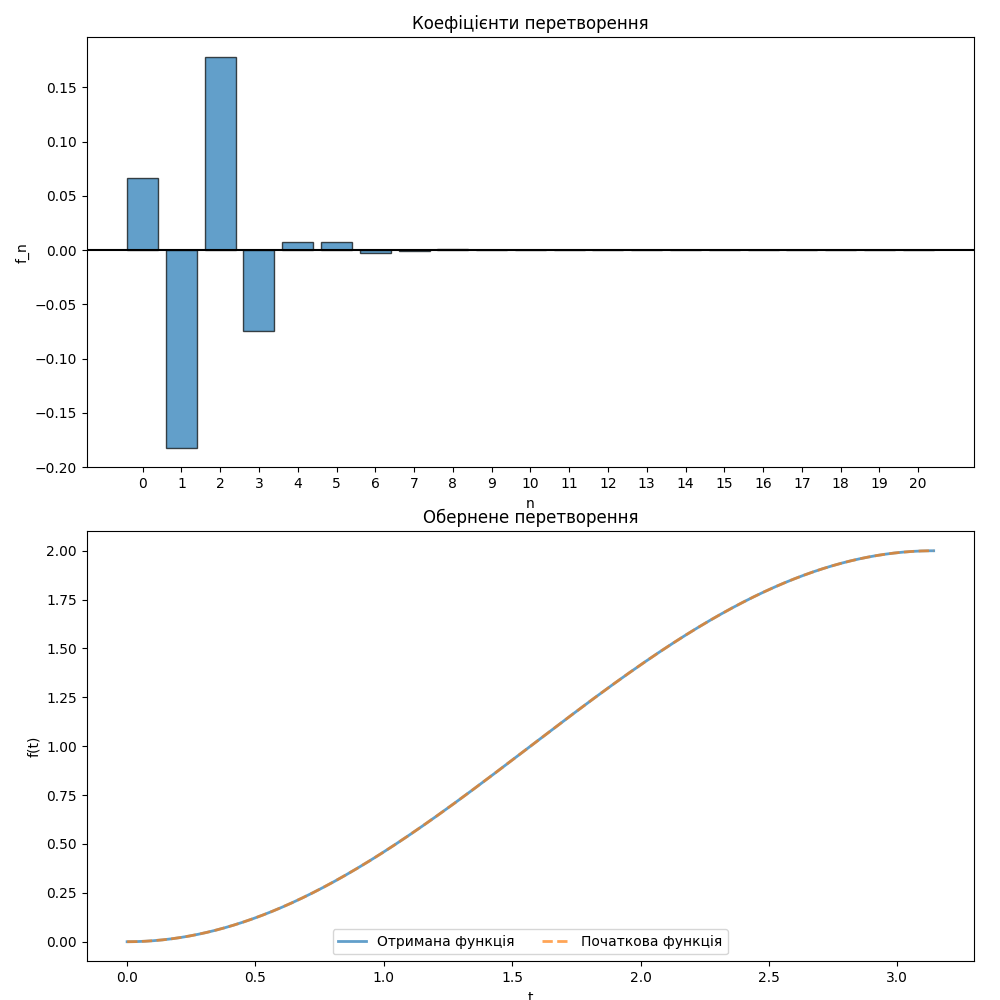

In [64]:
reversed_read = read_lines("Lagger\\Lagger\\tabulateReverseTransform.csv")
transform_read = read_lines("Lagger\\Lagger\\tabulateTransform.csv")

plotter.plot_tranformations_manual(f, transform_read, reversed_read, 0, np.pi)

In [71]:
def Gauss(mu, lambd):
    def func(t):
        exponent = -((t - mu)**2) / (2 * (lambd**2))
        denominator = lambd * np.sqrt(2 * np.pi)

        return np.exp(exponent) / denominator
    return func


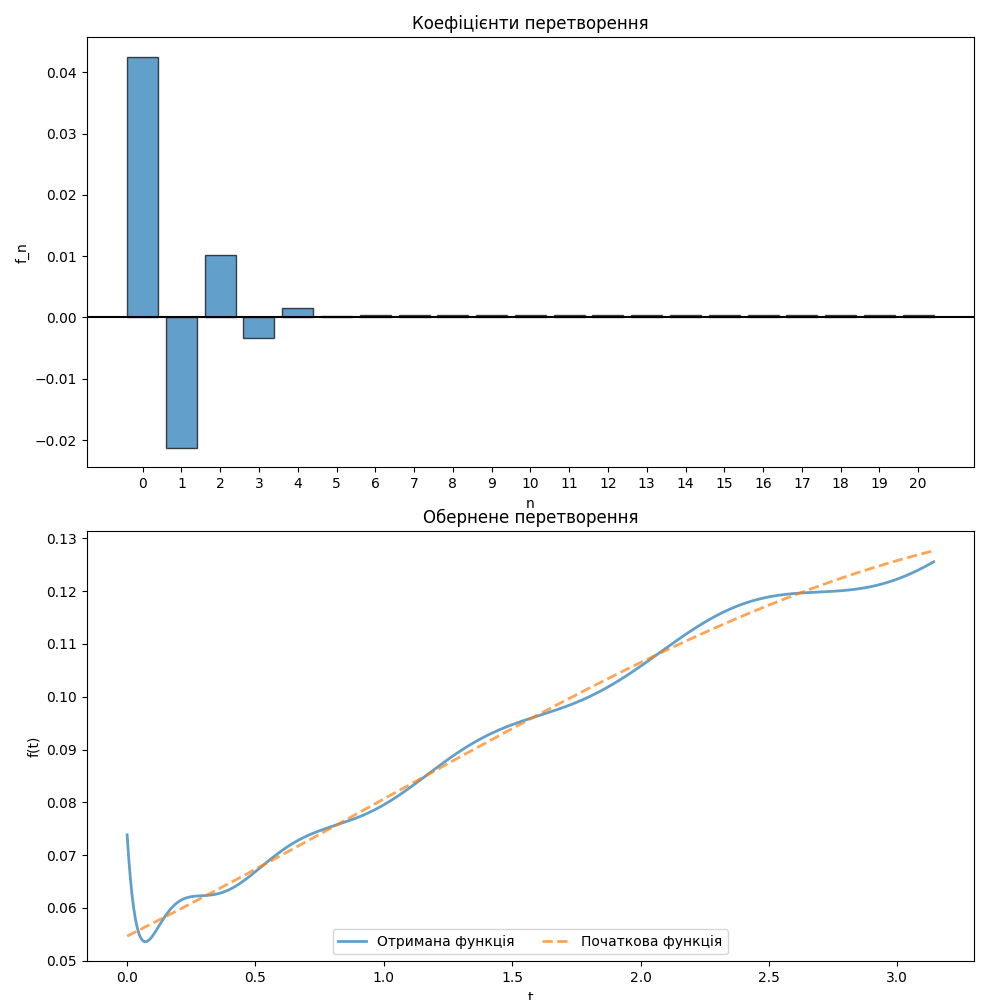

In [74]:
exp1_reversed = read_lines("Lagger\\Lagger\\tabulateReverseGauss1.csv")
exp1_tabulate = read_lines("Lagger\\Lagger\\gausTransformTabulate.csv")

plotter.plot_tranformations_manual(Gauss(4, 3), exp1_tabulate, exp1_reversed, 0, np.pi)

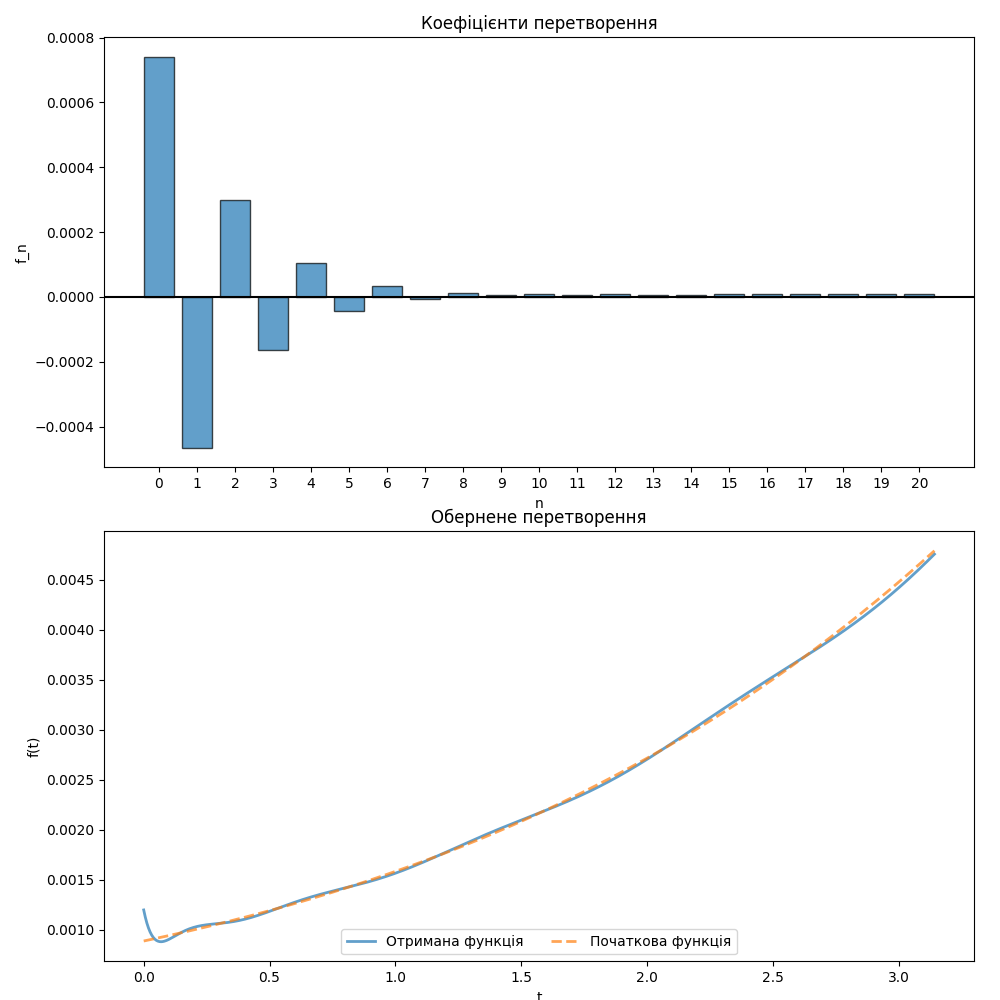

In [75]:
exp3_reversed = read_lines("Lagger\\Lagger\\tabulateReverseGauss3.csv")
exp3_tabulate = read_lines("Lagger\\Lagger\\gaus_transform_tabulate_exp_3.csv")

plotter.plot_tranformations_manual(Gauss(15, 5), exp3_tabulate, exp3_reversed, 0, np.pi)

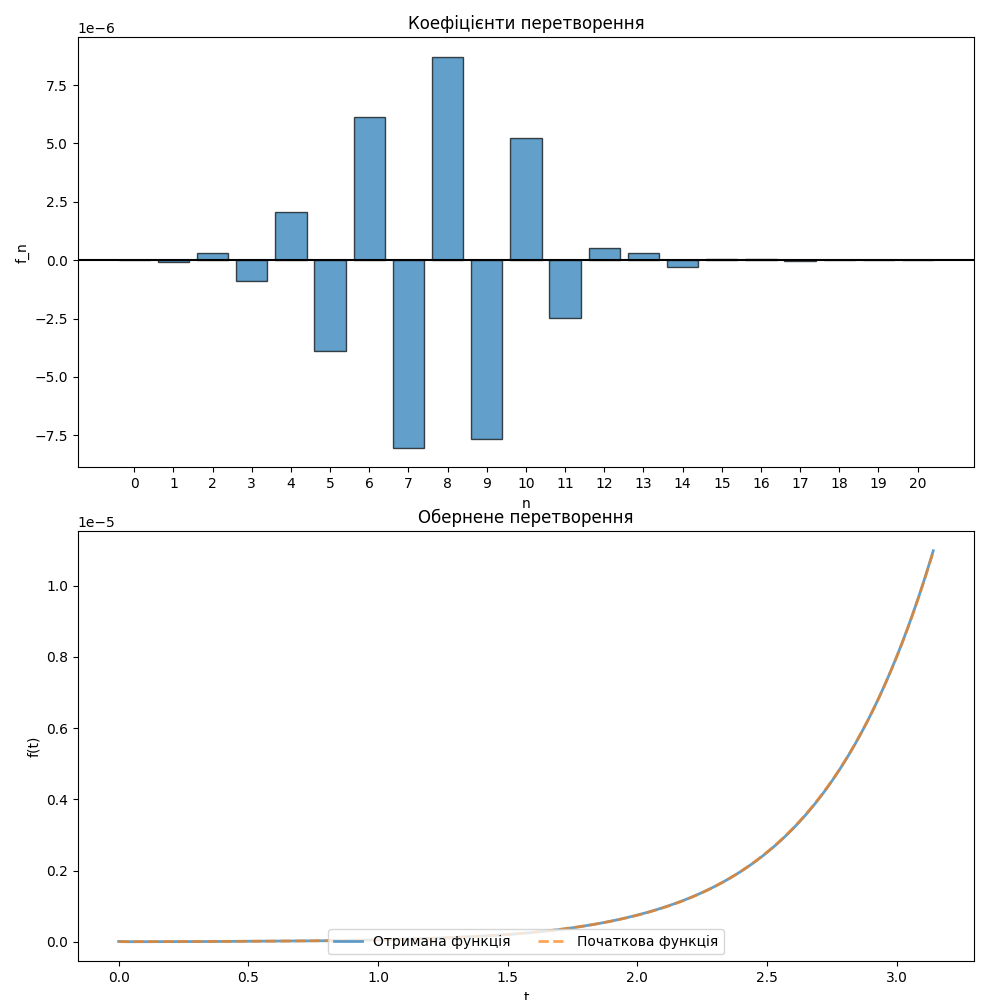

In [77]:
exp6_reversed = read_lines("Lagger\\Lagger\\tabulateReverseGauss6.csv")
exp6_tabulate = read_lines("Lagger\\Lagger\\gaus_transform_tabulate_exp_6.csv")

plotter.plot_tranformations_manual(Gauss(12, 2), exp6_tabulate, exp6_reversed, 0, np.pi)